# Some magic, imports and constants

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.dpi'] = 200

In [2]:
import os
import io
from time import time

import numpy as np


from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [3]:
ROOT_DATA_PATH = '/media/vp/cdata/oxford-iiit'
IMAGES_PATH = os.path.join(ROOT_DATA_PATH, 'images')
MASKS_PATH = os.path.join(ROOT_DATA_PATH, 'annotations/trimaps')

INPUT_SIZE = (256, 256)

BATCH_SIZE = 15

EPOCHS = 50

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load the data

In [5]:
images = []
masks = []
for file in tqdm(os.listdir(IMAGES_PATH)):
    image_path = os.path.join(IMAGES_PATH, file)
    mask_path = os.path.join(MASKS_PATH, file)[:-4] + '.png'
    
    image = None
    mask = None

    try:
        image = imread(image_path) # read the image from disc
        image = resize(image, INPUT_SIZE, mode='constant', anti_aliasing=True) # resize and normilize the image
        image = np.rollaxis(image, 2, 0) # turn dimensions (256,256,3) -> (3, 256, 256)        
    except:
        print('Error reading image: ' + image_path)
        continue
        
    try:
        # read the trimap
        with open(mask_path, "rb") as fid:
            encoded_mask_png = fid.read()            
        encoded_png_io = io.BytesIO(encoded_mask_png)
        mask = imread(encoded_png_io)
        
        # select only object mask for now
        tmp_mask = np.zeros(mask.shape, dtype=float)
        tmp_mask[mask == 1] = 1
        mask = tmp_mask
        
        # resize the mask
        mask = resize(mask, INPUT_SIZE, mode='constant', anti_aliasing=False)
        
        # our UNet outputs (1, 256, 256) mask shall have same dimensions        
        tmp_mask = np.zeros((1, INPUT_SIZE[0], INPUT_SIZE[1]))
        tmp_mask[0] = mask                       
        mask = tmp_mask
    except:
        print('Error reading mask: ' + mask_path)
        continue
        
    if image is None or mask is None:
        continue

    if len(image.shape) != 3 or image.shape[0] != 3:
        print('Expected 3 channels. But got ' + str(image.shape) + ' in ' + image_path)
        continue

    images.append(image)
    masks.append(mask)

Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_186.jpg
Error reading image: /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_129.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_14.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_145.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_167.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_177.jpg
Error reading image: /media/vp/cdata/oxford-iiit/images/staffordshire_bull_terrier_22.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Abyssinian_34.jpg
Expected 3 channels. But got (4, 256, 256) in /media/vp/cdata/oxford-iiit/images/Egyptian_Mau_191.jpg
Error reading image: /media/vp/cdata/oxford-iiit/images/Abyssinian_100.mat
Expected 3 channels. But got (4, 256, 256) in /m

Few images failed to read or have alpha channel - we will skip those files for now.

In [6]:
len(images), len(masks)

(7378, 7378)

In [7]:
images[0].shape

(3, 256, 256)

In [8]:
masks[0].shape

(1, 256, 256)

## Display few examples

In [9]:
def display(display_X, display_Y):
    n_images = len(display_X)
    plt.figure(figsize=(18, n_images))
    for i in range(n_images):
        plt.subplot(2, n_images, i+1)
        plt.axis("off")
        plt.imshow(np.rollaxis(display_X[i], 0, 3))

        plt.subplot(2, n_images, i+n_images+1)
        plt.axis("off")        
        plt.imshow(display_Y[i][0])
    plt.show();

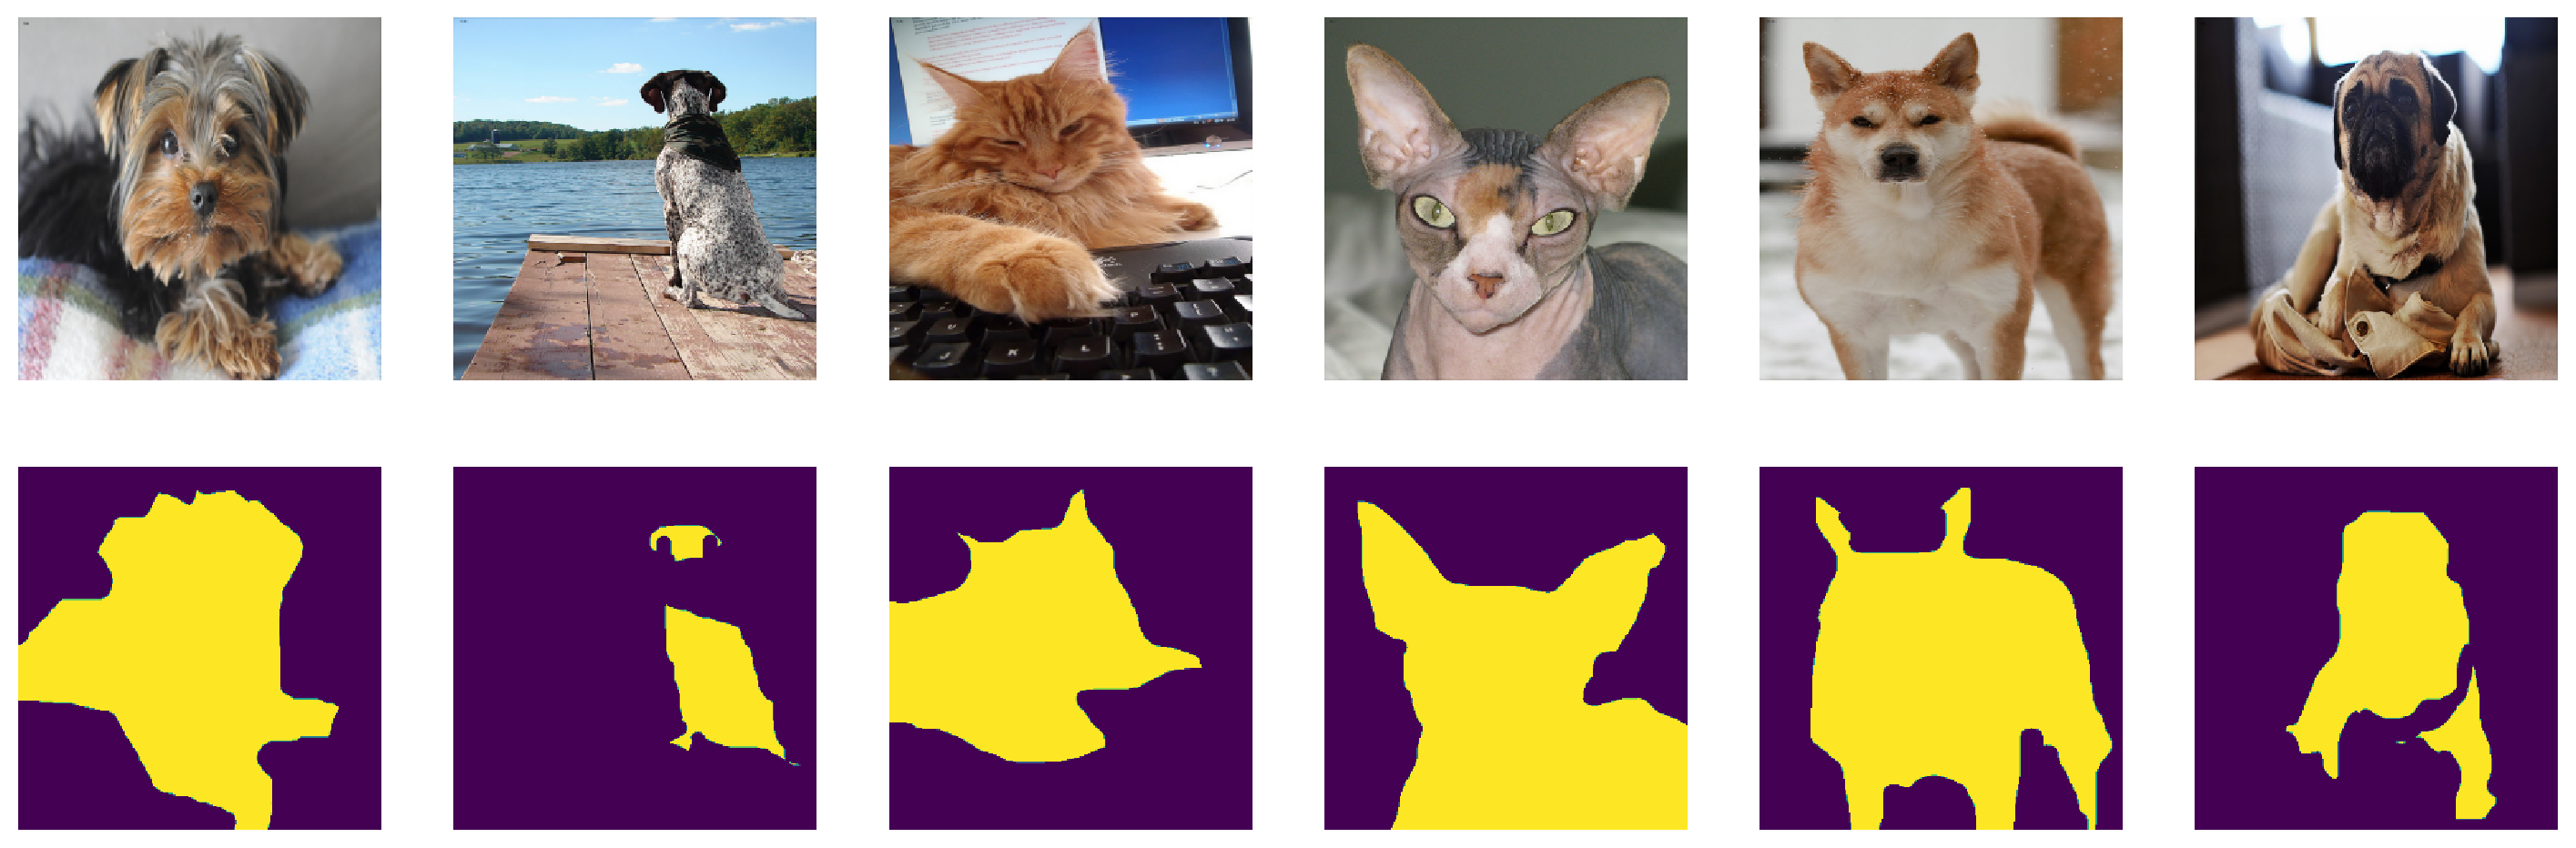

In [10]:
display(images[:6], masks[:6])

Looks good!

## Split the data

In [11]:
X_train, X_tmp, y_train, y_tmp = train_test_split(images, masks, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

Out split of data is following:

In [12]:
len(X_train), len(X_val), len(X_test)

(6640, 369, 369)

## Create pytorch data loaders

In [13]:
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=1, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=1, shuffle=True)

# Define a model

In [14]:
class UNet(nn.Module):

    def __init__(self, n_out_layers=1):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = self.make_encoder_layer(3, 32, 2)
        self.pool_0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False)
        self.enc_conv1 = self.make_encoder_layer(32, 64, 2)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False)
        self.enc_conv2 = self.make_encoder_layer(64, 128, 2)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False)
        self.enc_conv3 = self.make_encoder_layer(128, 256, 2)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False)

        # decoder (upsampling)
        self.up0 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv0 = self.make_decoder_layer(512, 256, 2)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv1 = self.make_decoder_layer(384, 128, 2)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv2 = self.make_decoder_layer(192, 64, 2)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv3 = self.make_decoder_layer(96, 32, 1)

        self.dec_conv3_2 = nn.Conv2d(in_channels=32,
                                     out_channels=n_out_layers,
                                     kernel_size=3,
                                     padding=1)

        self.sm = nn.Sigmoid()

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool_0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool_1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool_2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool_2(e3)

        # decoder
        up0 = self.up0(p3)
        s0 = torch.cat((e3, up0), 1)
        d0 = self.dec_conv0(s0)

        up1 = self.up1(d0)
        s1 = torch.cat((e2, up1), 1)
        d1 = self.dec_conv1(s1)

        up2 = self.up2(d1)
        s2 = torch.cat((e1, up2), 1)
        d2 = self.dec_conv2(s2)

        up3 = self.up3(d2)
        s1 = torch.cat((e0, up3), 1)
        d3 = self.dec_conv3(s1)  # no activation

        d3_2 = self.dec_conv3_2(d3)

        return self.sm(d3_2)

    def make_encoder_layer(self, in_channels, out_channels, n_layers=1):
        layers = [
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

        for _ in range(1, n_layers):
            layers.extend([
                nn.Conv2d(in_channels=out_channels,
                          out_channels=out_channels,
                          kernel_size=3,
                          padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            ])
        return nn.Sequential(*layers)

    def make_decoder_layer(self, in_channels, out_channels, n_layers=1):
        layers = [
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

        for _ in range(1, n_layers):
            layers.extend([
                nn.Conv2d(in_channels=out_channels,
                          out_channels=out_channels,
                          kernel_size=3,
                          padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            ])

        return nn.Sequential(*layers)


# Train and score functions

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

In [16]:
def score_model(model, loss_fn, acc_metric, data):
    model.eval()
    
    loss = 0.0
    scores = 0.0
    for X_batch, Y_label in data:
        Y_label = Y_label.float()        
        Y_pred = model(X_batch.float().to(device)).detach().cpu()
        
        loss += loss_fn(Y_pred, Y_label).item()
        scores += acc_metric(torch.round(Y_pred), Y_label).mean().item()

    return loss/len(data), scores/len(data)

In [17]:
def train(model, opt, loss_fn, epochs, acc_metric, data_tr, data_val):
    result = []    
    best_acc = 0.0

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))        

        avg_loss = 0
        avg_acc = 0
        for X_batch, Y_batch in data_tr:
            model.train()  # train mode
            # data to device
            X_batch = X_batch.float().to(device)
            Y_batch = Y_batch.float().to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            
            model.eval()
            avg_acc += acc_metric(torch.round(Y_pred), Y_batch).mean().item() / len(data_tr)           

        toc = time()
        val_loss, val_acc = score_model(model, loss_fn, acc_metric, data_val)
        print('    train loss: %f' % avg_loss)
        print('    train accuracy: %f' % avg_acc)
        print('    validation loss: %f' % val_loss)
        print('    validation accuracy: %f' % val_acc)
        result.append((epoch+1, loss, avg_acc, val_loss, val_acc))
        
        
        if best_acc < val_acc:
            model_file = 'model_epoch' + str(epoch) +'.pytorch'
            print('    saved model to: ' + model_file)
            torch.save(model.state_dict(), model_file)
            best_acc = val_acc

        # visual debug - uncomment if needed
        """
        # show intermediate results
        model.eval()  # testing mode
        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

        # Visualize tools         
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        """
    return result

# Drumbeat! Training the model

In [18]:
unet_model = UNet().to(device)

In [19]:
optimizer = torch.optim.Adam(unet_model.parameters())
criterion = nn.BCELoss()

In [20]:
results = train(unet_model, optimizer, criterion, EPOCHS, iou_pytorch, train_loader, val_loader)

* Epoch 1/50


/home/vp/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


    train loss: 0.432769
    train accuracy: 0.153830
    validation loss: 0.338156
    validation accuracy: 0.271003
    saved model to: model_epoch0.pytorch
* Epoch 2/50
    train loss: 0.315403
    train accuracy: 0.321911
    validation loss: 0.481764
    validation accuracy: 0.278320
    saved model to: model_epoch1.pytorch
* Epoch 3/50
    train loss: 0.264288
    train accuracy: 0.423243
    validation loss: 0.245694
    validation accuracy: 0.446883
    saved model to: model_epoch2.pytorch
* Epoch 4/50
    train loss: 0.236905
    train accuracy: 0.479601
    validation loss: 0.253502
    validation accuracy: 0.470461
    saved model to: model_epoch3.pytorch
* Epoch 5/50
    train loss: 0.220548
    train accuracy: 0.515658
    validation loss: 0.217880
    validation accuracy: 0.511382
    saved model to: model_epoch4.pytorch
* Epoch 6/50
    train loss: 0.206633
    train accuracy: 0.542807
    validation loss: 0.221976
    validation accuracy: 0.542276
    saved model to: mo

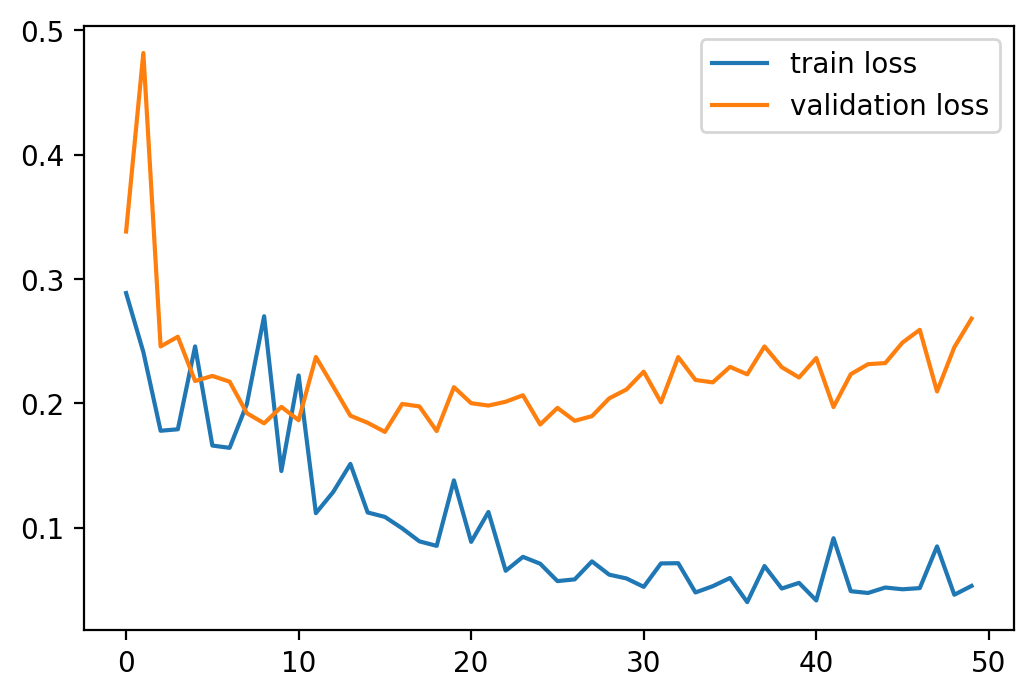

In [22]:
plt.plot([(v[1], v[3]) for v in results])
plt.legend(('train loss', 'validation loss'))

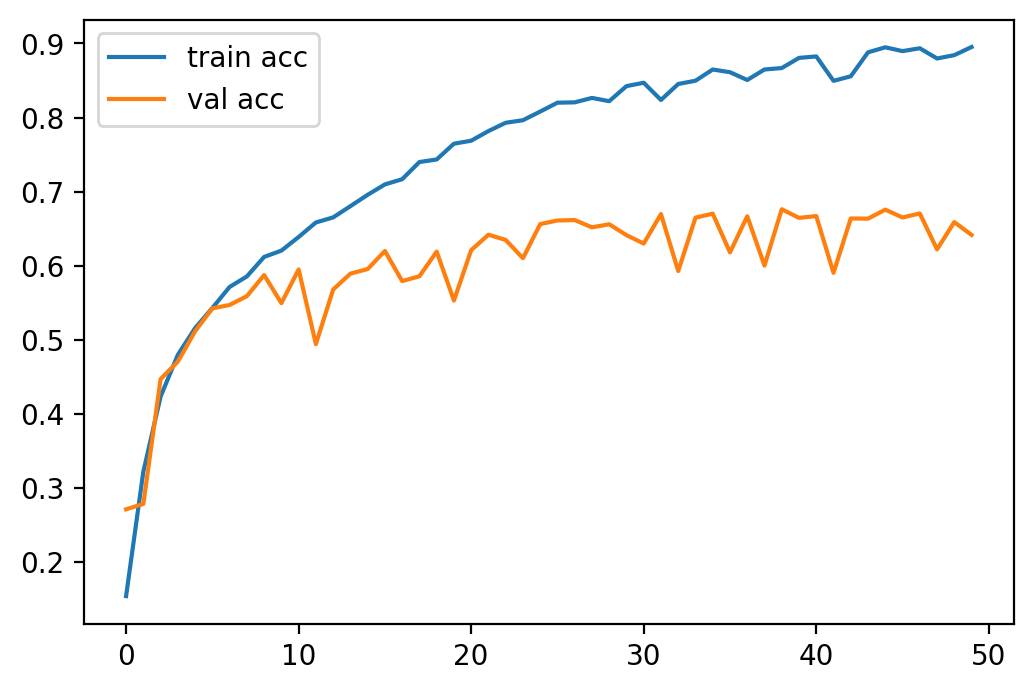

In [23]:
plt.plot([(v[2], v[4]) for v in results])
plt.legend(('train acc', 'val acc'))

# Load the best model

In [25]:
best_iteration = len(results)-1
best_score = 0
for result in results:
    if result[4] > best_score:
        best_score = result[4]
        best_iteration = result[0]
best_score,best_iteration

(0.6761517610128333, 39)

In [26]:
print('Best iteration is #' + str(best_iteration))

Best iteration is #39


In [28]:
unet_model.load_state_dict(torch.load('model_epoch' + str(best_iteration-1) +'.pytorch'))

<All keys matched successfully>

In [29]:
test_score = score_model(unet_model, nn.BCELoss(), iou_pytorch, test_loader)
test_score[0], test_score[1]

(0.1733130467828454, 0.692140919365857)

# Try a random image from the test set

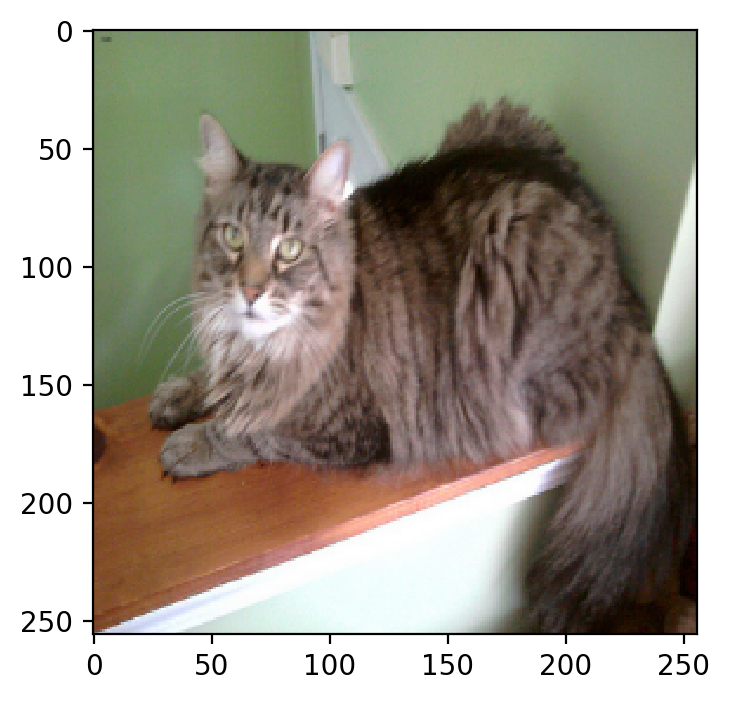

In [37]:
random_int = np.random.randint(0, len(X_test))
test_image = X_test[random_int]
test_mask = y_test[random_int]
plt.imshow(np.rollaxis(test_image, 0, 3))

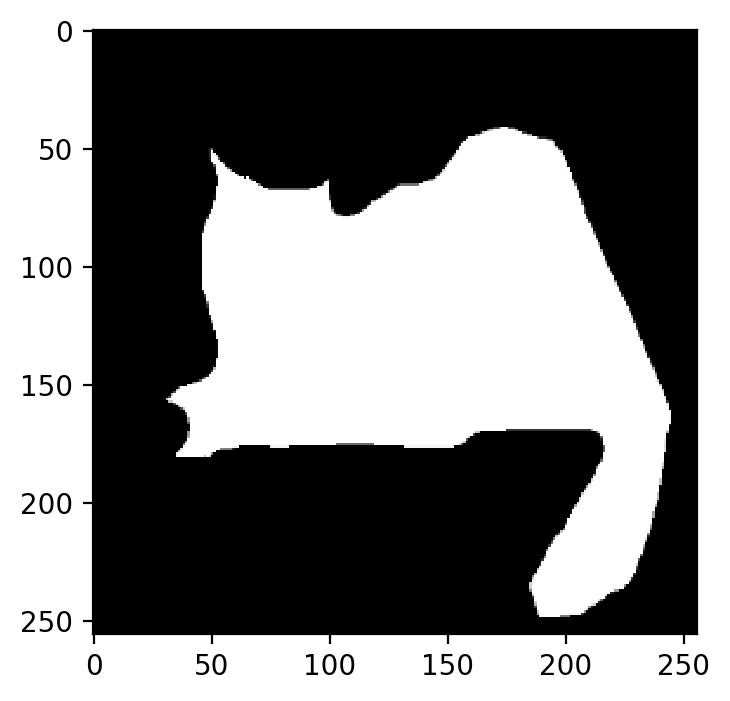

In [38]:
plt.imshow(test_mask[0], cmap='gray')

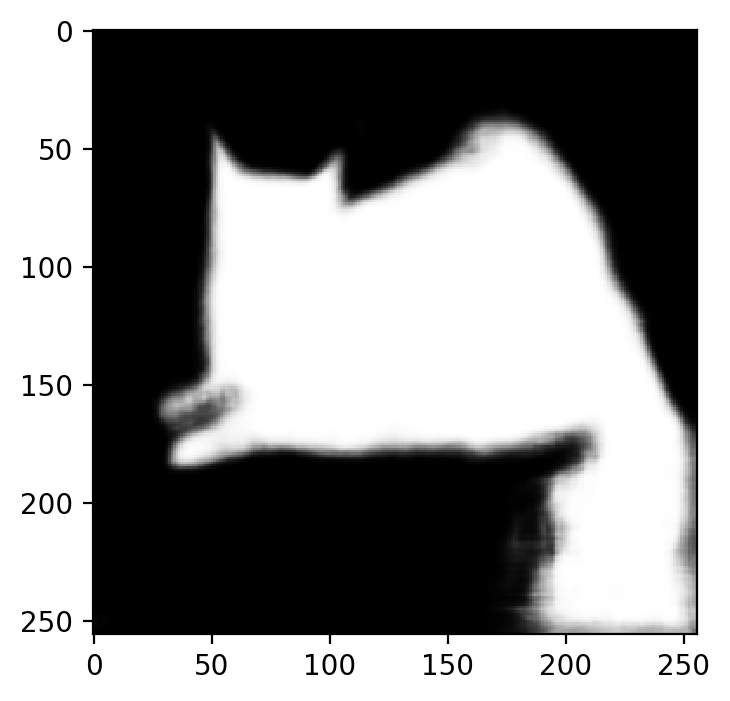

In [39]:
unet_model.eval()
model_input = torch.zeros((1, 3, INPUT_SIZE[0], INPUT_SIZE[1])).to(device)
model_input[0] = torch.from_numpy(test_image)
output = unet_model(model_input).detach().cpu().numpy()
plt.imshow(output[0, 0], cmap='gray')

Looks good!